# Ⅵ. 통계적 머신러닝

In [1]:
import math
import os
import random
from collections import defaultdict
from itertools import product

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. k-최근접 이웃(KNN)
---
- **이웃(neighbor)**: 독립변수에서 값들이 유사한 레코드
- **거리 지표(distance metric)**: 각 레코드 사이가 얼마나 멀리 떨어져 있는지를 나타내는 단일 값
- **표준화(standardization)**: 평균을 뺀 후에 표준편차로 나누는 일
    - 유의어 - 정규화
- **z 점수(z-score)**: 표준화를 통해 얻은 값
- **k**: 최근접 이웃을 계산하는 데 사용되는 이웃의 개수

- 과정
    1. 특징들이 가장 유사한(즉, 독립변수들이 유사한) k개의 레코드를 찾는다.
    1. 분류: 이 유사한 레코드들 중에 다수가 속한 클래스가 무엇인지 찾은 후, 새로운 레코드를 그 클래스에 할당한다.
    1. 예측(KNN 회귀): 유사한 레코드들의 평균을 찾아서 새로운 레코드에 대한 예측값으로 사용한다.
- 특징
    - 가장 간단한 예측/분류 방법 중 하나
    - 회귀와는 달리 모델을 피팅하는 과정이 필요 없음
    - 완전히 자동화된 방법은 아니므로 아래에 따라 예측 결과가 달라짐
        - 피처들이 어떤 척도에 존재하는지
        - 가까운 정도를 어떻게 측정할 것인지
        - k를 어떻게 설정할 것인지
    - 모든 독립변수들은 수치형이어야 함

### A. 예제: 대출 연체 예측

In [3]:
loan200 = pd.read_csv('../data/loan200.csv')
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


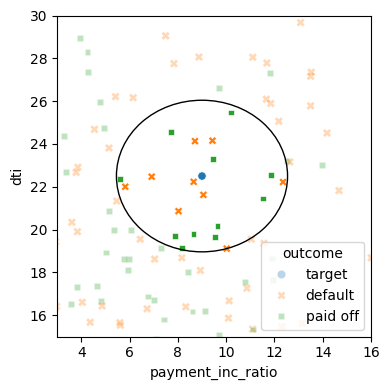

In [4]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',
                hue='outcome',
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]),
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0],
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

- target(●) = 새로운 대출에 대한 예측 결과
- paid off(■) = 학습 데이터, 상환
- default(X) = 학습 데이터, 연체
- 검은 실선 원 = 가장 가까운 20개 점들에 대한 경계선
- 9번의 연체와 11번의 상환 발생 -> 예측 결과 = 상환

### B. 거리 지표
---
- 유사성(similarity)=근접성(nearness)은 거리 지표를 통해 결정됨
    - 거리 지표 = $(x_1, x_2, \cdots, x_p)$와 $(u_1, u_2, \cdots, u_p)$가 서로 얼마나 멀리 떨어져 있는지를 측정하는 함수
- **유클리드 거리(Euclidean distance)**
    - $\sqrt{(x_1-u_1)^2+(x_2-u_2)^2+\cdots+(x_p-u_p)^2}$
    - 가장 많이 사용됨
    - 두 점 사이의 직선 거리
- **맨해튼 거리(Manhattan distance)**
    - $|x_1-u_1|+|x_2-u_2|+\cdots+|x_p-u_p|$
    - 유클리드 거리 다음으로 많이 사용됨
    - 한 번에 대각선이 아닌 한 축 방향으로만 움직일 수 있다고 할 때, 두 점 사이의 거리
- **마할라노비스 거리(Mahalanobis distance)**
    - 두 변수 간의 상관관계 사용
    - 주성분 사이의 유클리드 거리
    - 계산에 공분산행렬을 사용하므로 많은 계산이 필요하고 복잡성이 증가한다.

### C. 원-핫 인코더

### D. 표준화(정규화, z 점수)

In [5]:
loan_data = pd.read_csv('../data/loan_data.csv')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                      categories=['paid off', 'default'],
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [6]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


```
TIP

z 점수는 변수를 변환하는 여러 방법 중 한 가지일 뿐이다.
평균 대신 중간값 같은 좀 더 로버스트한 위치 추정값을 사용할 수도 있다.
표준편차 대신에 사분위범위 같은 다른 척도 추정 방법을 사용할 수 있다.
단위 분산을 갖도록 모든 변수를 조정하는 것이 다소 억지스러울 수 있다는 것을 인식하는 것도 중요하다.
```

### E. k 선택하기
---
- k가 너무 작으면 데이터의 노이즈 성분까지 고려하는 오버피팅 문제 발생
- k가 너무 크면 결정함수가 과하게 평탄화되어(오버스무딩) KNN의 기능을 잃어버리게 됨
- 최적의 k를 찾기 위해 정확도 지표들을 활용
- 신호 대 잡음비(SNR)
    - SNR이 높은 데이터 -> k가 작을수록 잘 동작함
        - 노이즈가 거의 없고 아주 잘 구조화된 데이터
        - 손글씨 데이터 혹은 음성 인식 데이터 등
    - SNR이 낮은 데이터 -> k가 클수록 좋음
        - 노이즈가 많은 데이터
        - 대출 데이터 등
- 보통 1에서 20 사이에 놓으며, 동률을 막기 위해 홀수를 선호함

### F. KNN을 통한 피처 엔지니어링

count    45342.000000
mean         0.501091
std          0.128728
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


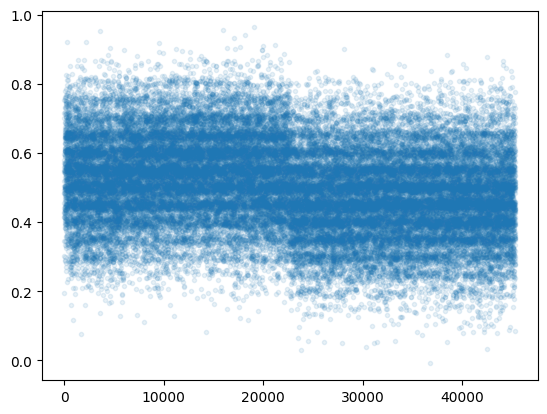

In [7]:
loan_data = pd.read_csv('../data/loan_data.csv')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                      categories=['paid off', 'default'],
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc',
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]],
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

## 2. 트리 모델
---
- **재귀 분할(recursive partitioning)**: 마지막 분할 영역에 해당하는 출력이 최대한 비슷한(homogeneous) 결과를 보이도록 데이터를 반복적으로 분할하는 것
- **분할값(split value)**: 분할값을 기준으로 예측변수를 그 값보다 작은 영역과 큰 영역으로 나눔
- **마디(node)**: 의사 결정 트리와 같은 가지치기 형태로 구성된 규칙들의 집합에서, 노드는 분할 규칙의 시각적인 표시라고 할 수 있음
- **잎(leaf)**: if-then 규칙의 가장 마지막 부분, 혹은 트리의 마지막 가지(branch) 부분을 의미
    - 트리 모델에서 잎 노드는 어떤 레코드에 적용할 최종적인 분류 규칙을 의미
- **손실(loss)**: 분류하는 과정에서 발생하는 오분류의 수로, 손실이 클수록 불순도가 높다고 할 수 있음
- **불순도(impurity)**: 데이터를 분할한 집합에서 서로 다른 클래스의 데이터가 얼마나 섞여 있는지를 나타내며, 더 많이 섞여 있을수록 불순도가 높다고 할 수 있음
    - 유의어 - 이질성(heterogeneity)
    - 반의어 - 동질성(homogeneity), 순도
- **가지치기(pruning)**: 학습이 끝난 트리 모델에서 오버피팅을 줄이기 위해 가지들을 하나씩 잘라내는 과정

### A. 간단한 예제

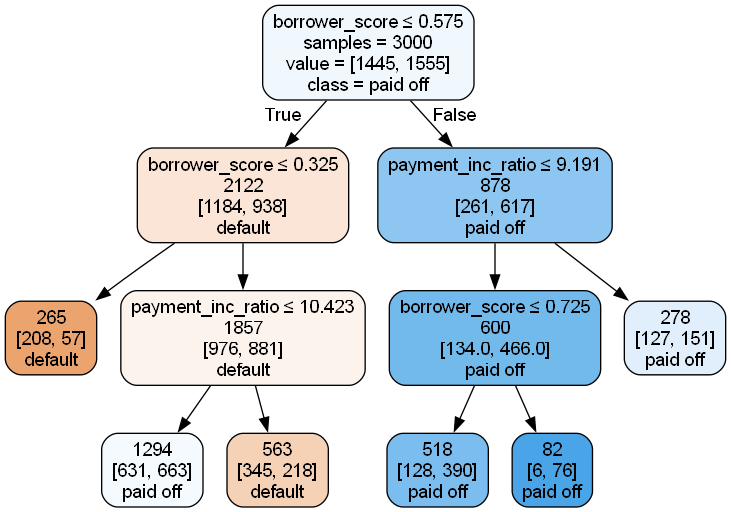

In [8]:
loan3000 = pd.read_csv('../data/loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

In [9]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


### B. 재귀 분할 알고리즘

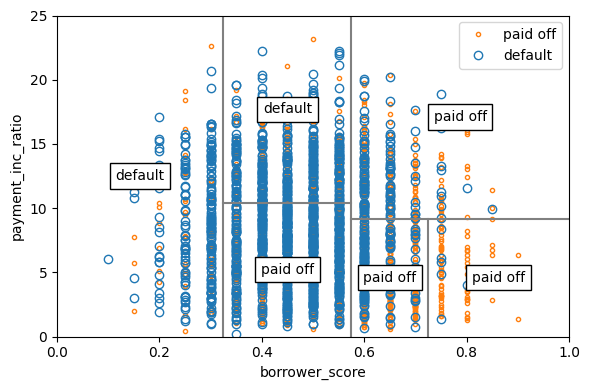

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

### C. 동질성과 불순도 측정하기
---
- 지니 불순도(Gini impurity)
    - $I(A)=p(1-p)$
- 엔트로피(entropy)
    - $I(A)=-p\log_2(p)-(1-p)\log_2(1-p)$

```
※ 지니 불순도 vs 지니 계수(Gini coefficient)

둘 다 모두 개념적으로 비슷하지만 지니 계수는 이진 분류 문제로 한정되며, AUC 지표와 관련이 있는 용어다.
```

In [11]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

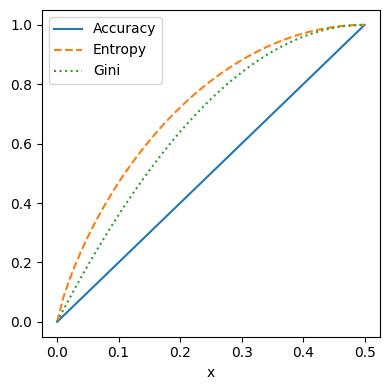

In [12]:

x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

### D. 트리 형성 중지하기
---
- 분할을 통해 얻어지는 하위 영역 또는 말단 잎의 크기가 너무 작다면 분할 중단
    - 파이썬 `DecisionTreeClassifier`에서 인수 `min_samples_split`(기본값 2)과 `min_samples_leaf`(기본값 1)
- 새로운 분할 영역이 '유의미'한 정도로 불순도를 줄이지 않는다면 굳이 분할하지 않는다.
    - 파이썬 `DecisionTreeClassifier`에서 인수 `min_impurity_decrease`가 있으며, 이는 가중불순도 감소값에 따라 분할을 제한함
- 파이썬에서 트리 복잡도 제어
    - `cpp_alpha`
        - 기본값은 0이며 이땐 트리를 가지치기하지 않음
        - 값이 높아질수록 트리는 작아짐
        - `GridSearchCV`를 사용하여 최적의 값을 찾을 수 있음
    - `max_depth` = 5~30
    - `min_samples_split` = 20~100


### E. 연속값 예측하기

### F. 트리 활용하기
---
- 트리 모델의 장점
    - 데이터 탐색을 위한 시각화가 가능함
        - 어떤 변수가 중요하고 변수 간에 어떤 관계가 있는지를 보여줌
        - 독립변수들 간의 비선형 관계를 담아낼 수 있음
    - 일종의 규칙들의 집합(set of rules)이라고 볼 수 있음
        - 비전문가들과 대화하는 데 아주 효과적이라고 할 수 있음

## 3. 배깅과 랜덤 포레스트
---
- **앙상블(ensemble)**: 여러 모델의 집합을 이용해서 하나의 예측을 이끌어내는 방식
    - 유의어 - 모델 평균화
- **배깅(bagging)**: 데이터를 부트스트래핑해서 여러 모델을 만드는 일반적인 방법
    - 유의어 - 부트스트랩 종합
- **랜덤 포레스트(random forest)**: 의사 결정 트리 모델에 기반을 둔 배깅 추정 모델
    - 유의어 - 배깅 의사 결정 트리
- **변수 중요도(variable importance)**: 모델 성능에 미치는 예측변수의 중요도

- 앙상블 방법의 가장 간단한 버전
    1. 주어진 데이터에 대해 예측 모델을 만들고 예측 결과를 기록한다.
    1. 같은 데이터에 대해 여러 모델을 만들고 결과를 기록한다.
    1. 각 레코드에 대해 예측된 결과들의 평균(또는 가중평균, 다수결 투표)을 구한다.

### A. 배깅
---
- 부트스트랩 종합(bootstrap aggregating)의 줄임말
- 다양한 모델들을 정확히 같은 데이터에 대해 구하는 대신, 매번 부트스트랩 재표본에 대해 새로운 모델을 만듦

### B. 랜덤 포레스트
---
- 의사 결정 트리 모델에 한 가지 중요한 요소가 추가된 배깅 방법을 적용한 모델
- 한 가지 중요한 요소 -> 레코드를 표본추출할 때 변수 역시 샘플링하는 것

In [13]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1,
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


In [14]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n,
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

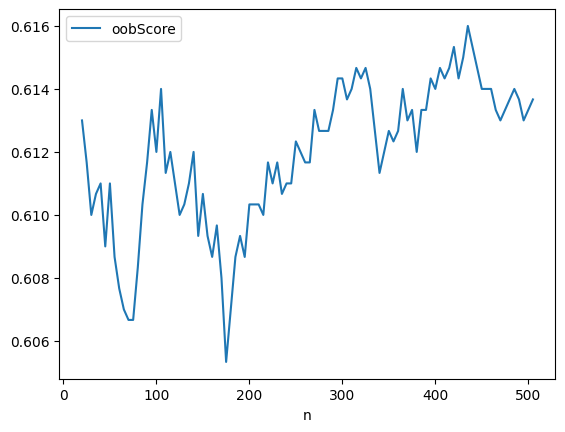

In [15]:
pd.DataFrame({
    'n': n_estimator,
    'oobScore': oobScores
}).plot(x='n', y='oobScore')
plt.show()

- 주머니 외부(out-of-bag, OOB) 추정 에러 = 트리 모델을 만들 때 사용했던 학습 데이터에 속하지 않는 데이터를 사용해 구한, 학습된 모델의 오차율

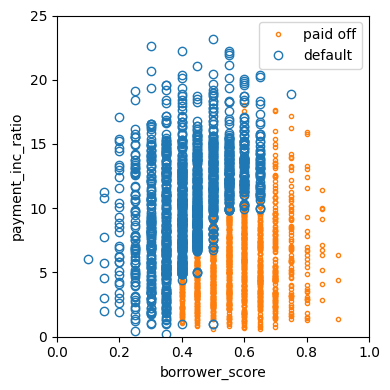

In [16]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### C. 변수 중요도
---
- 랜덤 포레스트는 다수의 독립변수 중 어떤 것이 중요한지, 그리고 이들 사이에 존재하는 상관관계 항들에 대응되는 복잡한 관계들을 자동으로 결정하는 능력이 있음
- 측정 방법
    - 변수의 값을 랜덤하게 섞었다면, 모델의 정확도가 감소하는 정도를 측정(type=1)
        - 변수를 랜덤하게 섞는다=해당 변수가 예측에 미치는 모든 영향력을 제거한다
        - 정확도는 OOB 데이터로부터 얻음
        - 결국 교차타당성검사와 같은 효과를 가짐
    - 특정 변수를 기준으로 분할이 일어난 모든 노드에서 불순도 점수의 평균 감소량을 측정(type=2)
        - 해당 변수를 포함하는 것이 노드의 순도를 얼마나 개선하는지를 나타냄
        - 학습 데이터를 기반으로 측정되기 때문에, OOB 데이터를 가지고 계산한 것에 비해 믿을 만하지 않음

In [17]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti',
              'payment_inc_ratio', 'revol_bal', 'revol_util',
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero',
              'open_acc', 'grade', 'emp_length', 'purpose_',
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In [18]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)

# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y,
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0706, 'borrower_score'), (0.0384, 'grade'), (0.0305, 'term_60 months'), (0.0116, 'annual_inc'), (0.0087, 'payment_inc_ratio'), (0.0036, 'dti'), (0.0021, 'revol_bal'), (0.0018, 'purpose_small_business'), (0.0013, 'open_acc'), (0.0012, 'pub_rec_zero'), (0.0011, 'home__RENT'), (0.0009, 'purpose_credit_card'), (0.0008, 'revol_util'), (0.0008, 'emp_length'), (0.0007, 'purpose__small_business'), (0.0004, 'purpose_vacation'), (0.0003, 'emp_len__ > 1 Year'), (0.0002, 'purpose_moving'), (0.0002, 'delinq_2yrs_zero'), (-0.0, 'purpose_other'), (-0.0, 'purpose_house'), (-0.0, 'purpose__medical'), (-0.0001, 'purpose_wedding'), (-0.0001, 'purpose__other'), (-0.0002, 'home__OWN'), (-0.0004, 'purpose_medical'), (-0.0004, 'purpose__major_purchase'), (-0.0006, 'purpose_home_improvement'), (-0.0006, 'purpose__home_improvement'), (-0.001, 'purpose_major_purchase'), (-0.0018, 'purpose__debt_consolidation'), (-0.0021, 'loan_amnt'), (-0.0023, 'purpose_debt_consolidation')]


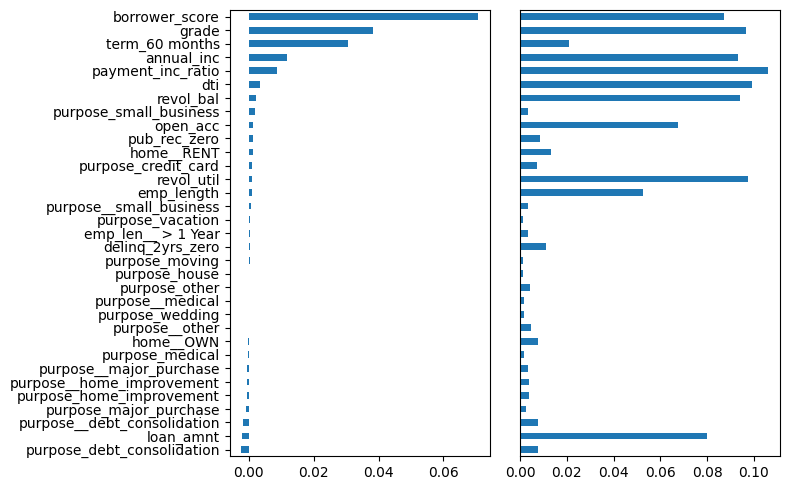

In [19]:
importances = rf_all.feature_importances_ # 학습 중에 피처의 중요도에 대해 수집한 정보 사용

df = pd.DataFrame({
    'feature': X.columns,
    'Accuracy decrease': [np.mean(scores[column]) for column in
                         X.columns],
    'Gini decrease': rf_all.feature_importances_,
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease',
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease',
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

### D. 하이퍼파라미터
---
- `nodesize(min_samples_leaf)`
    - 말단 노드(나무에서 잎 부분)의 크기
    - 파이썬의 사이킷런에서는 기본값이 모두 1
- `maxnodes(max_leaf_nodes)`
    - 각 결정 트리에서 전체 노드의 최대 개수
    - 기본적으로는 제한이 없고 nodesize 제한 설정에 따라 가장 큰 트리의 크기가 결정됨
    - 파이썬에서는 최대 단말 노드 수 지정
    - maxnodes=2*max_leaf_nodes-1

## 4. 부스팅
---
- **앙상블(ensemble)**: 여러 모델들의 집합을 통해 예측 결과를 만들어내는 것
    - 유의어 - 모델 평균화
- **부스팅(boosting)**: 연속된 라운드마다 잔차가 큰 레코드들에 가중치를 높여 일련의 모델들을 생성하는 일반 기법
- **에이다부스트(AdaBoost)**: 잔차에 따라 데이터의 가중치를 조절하는 부스팅의 초기 버전
- **그레이디언트 부스팅(gradient boosting)**: 비용함수(cost function)를 최소화하는 방향으로 부스팅을 활용하는 좀 더 일반적인 형태
- **확률적 그레이디언트 부스팅(stochastic gradient boosting)**: 각 라운드마다 레코드와 열을 재표본추출하는 것을 포함하는 부스팅의 가장 일반적인 형태
- **정규화(regularization)**: 비용함수에 모델의 파라미터 개수에 해당하는 벌점 항을 추가해 오버피팅을 피하는 방법
- **하이퍼파라미터(hyperparameter)**: 알고리즘을 피팅하기 전에 미리 세팅해야 하는 파라미터

### A. 부스팅 알고리즘
---
- 에이다부스트 알고리즘
    1. 피팅할 모델의 개수 $M$ 설정 -> 반복 횟수를 의미하는 $m=1$로 초기화 & 관측 가중치 $w_i=1/N$으로 초기화$(i=1, 2, \cdots, N)$ & 앙상블 모델 $\hat{F}_0=0$으로 초기화
    1. 관측 가중치 $w_1, w_2, \cdots, w_N$을 이용해 모델 $\hat{f}_m$ 학습 / 이때 잘못 분류된 관측치에 대해 가중치를 적용한 합을 의미하는 가중 오차 $e_m$이 최소화되도록 학습
    1. 앙상블 모델에 다음 모델 추가: $\hat{F}_m=\hat{F}_{m-1}+\alpha_m \hat{f}_m \left(\alpha_m={ {\log1-e_m}\over{e_m} }\right)$
    1. 잘못 분류된 입력 데이터에 대한 가중치를 증가하는 방향으로 가중치 업데이트 ($\alpha_m$에 따라 증가 폭이 결정되며, $\alpha_m$이 클수록 가중치가 더 커짐)
    1. 모델 반복 횟수를 $m=m+1$로 증가시키고 $m<=M$이면 다시 2단계로
    - 부스팅 추정치: $\hat{F}=\alpha_1\hat{f_1}+\alpha_2\hat{f_2}+\cdots+\alpha_M\hat{f_M}$
- 그레이디언트 부스팅
    - 비용함수를 최적화하는 접근법 사용
    - 가중치를 조정하는 대신 모델이 유사잔차(pseudo-residual)를 학습하도록 함
- 확률절 그레이디언트 부스팅
    - 매 단계마다 데이터와 예측변수를 샘플링하는 식으로 그레이디언트 부스팅에 랜덤한 요소 추가

### B. XG부스트
---
- 부스팅 방법 가운데 대중적으로 가장 많이 사용되는 오픈소스 소프트웨어
- 확률적 그레이디언트 부스팅 구현

In [20]:
# subsample: 각 반복 구간마다 샘플링할 입력 데이터의 비율 조정
# learning rate: 부스팅 알고리즘에서 α_m에 적용되는 축소 비율 결정, 오버피팅 방지 효과
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63,
                    eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [21]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.586677
1            0.40            5.43165    default      0.307408
2            0.70            9.23003    default      0.337050
3            0.40            2.33482   paid off      0.861774
4            0.45           12.10320    default      0.056794


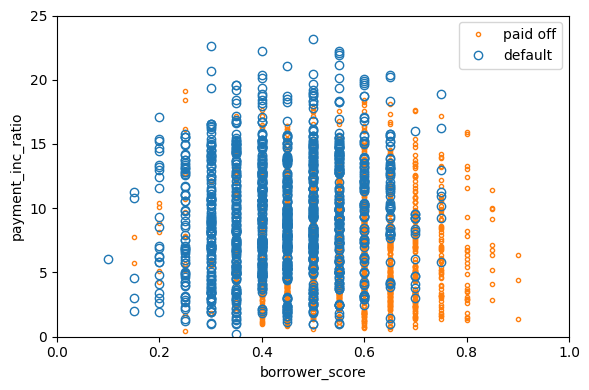

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

### C. 정규화: 오버피팅 피하기
---
- 오버피팅의 문제점
    - 학습 데이터에 없는 새로운 데이터에 대한 모델의 정확도가 떨어짐
    - 모델의 예측 결과에 변동이 매우 심하고 불안정한 결과를 보임

In [23]:
# reg_alpha: 맨해튼 거리(L1-정규화), 능형회귀(ridge regression)
# reg_lambda: 유클리드 거리(L2-정규화), 라소 회귀(Lasso regression)
# 위 파라미터들을 크게 하면 모델이 복잡해질수록 더 많은 벌점을 부여하고 결과적으로 얻는 트리의 크기가 작아짐
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti',
              'payment_inc_ratio', 'revol_bal', 'revol_util',
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero',
              'open_acc', 'grade', 'emp_length', 'purpose_',
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [24]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.10378586384471733
default:  0.3624
penalty:  0.3331


- 학습 데이터에 대한 오차율 - 10.5%
- 테스트 데이터에 대한 오차율 - 35.3%
- 이는 오버피팅의 결과임

In [25]:
results = []
for ntree_limit in range(1, 250):
    iteration_range = [1, ntree_limit + 1]
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.339228       0.351819        0.3552        0.3597
1           2       0.328618       0.342680        0.3483        0.3558
2           3       0.325279       0.340869        0.3447        0.3540
3           4       0.320950       0.339454        0.3401        0.3529
4           5       0.316734       0.335295        0.3435        0.3488


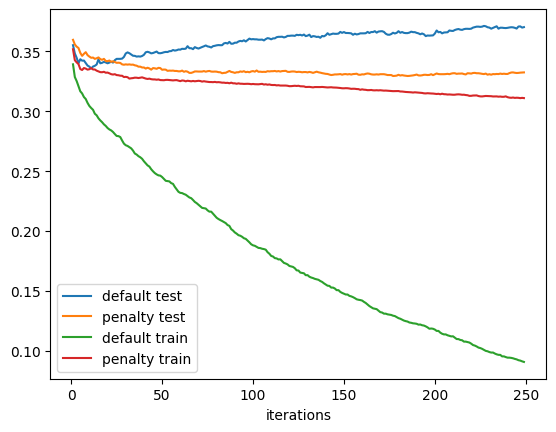

In [26]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

### D. 하이퍼파라미터와 교차타당성검사

In [27]:
# 두 하이퍼파라미터의 가능한 모든 조합을 만들기 위해 표준 라이브러리의 itertools.product 함수 사용
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250,
                        max_depth=max_depth, learning_rate=eta,
                        eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.32883230020900206}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.33525706759639856}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3459416457410247}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.34023311673375806}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.36855701226872795}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3721291666529995}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3529046130747203}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3886076107138082}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.38151702538228294}
   eta  max_depth  avg_error
0  0.1          3   0.328832
1  0.1          6   0.335257
2  0.1          9   0.345942
3  0.5          3   0.340233
4  0.5          6   0.368557
5  0.5          9   0.372129
6  0.9          3   0.352905
7  0.9          6   0.388608
8  0.9          9   0.381517


In [28]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.883230  33.525707  34.594165
0.5        34.023312  36.855701  37.212917
0.9        35.290461  38.860761  38.151703


- `eta(learning_rate)` 값이 작으면서 깊이가 얕은 트리를 사용하는 것이 좀 더 정확한 성능을 보임

- **XG부스트의 하이퍼파라미터**
    - `eta(learning_rate)`
        - 부스팅 알고리즘에서 $\alpha$에 적용되는 0과 1 사이의 축소인자(shringkage factor)
        - R에서 기본값은 0.3이지만, 노이즈가 있는 데이터에 대해서는 더 작은 값을 추천함(예를 들어 0.1)
        - 파이썬에서 기본값은 0.1
    - `nrounds(n_estimators)`
        - 부스팅 라운드 횟수
        - `eta`가 작은 값이라면 알고리즘의 학습 속도가 늦춰지기 때문에 라운드 횟수를 늘려야 함
        - 오버피팅을 방지하는 파라미터 설정이 포함된 경우, 라운드 횟수를 좀 더 늘려도 괜찮음
    - `max_depth`
        - 트리의 최대 깊이
        - R 기본값 6
        - 파이썬 기본값 3
        - 랜덤 포레스트와는 반대로 부스팅 트리는 깊이가 얕음 -> 노이즈가 많은 데이터에 대해 모델이 복잡한 거짓 상호작용을 회피하는 데 도움이 됨
    - `subsample` 및 `colsample_bytree`
        - 전체 데이터에서 일부 데이터를 비복원추출하는 비율 및 독립변수 중 일부 변수를 샘플링하는 비율
        - 랜덤 포레스트에서 오버피팅을 피하기 위해 사용했던 것들과 유사함
        - 기본값 1.0
    - `lambda(reg_lambda)` 및 `alpha(reg_alpha)`
        - 오버피팅을 조절하기 위해 사용되는 정규화 파라미터들
        - R에서는 두 값 모두 0이 기본값
        - 파이썬에서는 `reg_lambda`=1, `reg_alpha`=0이 기본값